In [1]:
import sys
sys.version

'3.6.3 (default, Oct  3 2017, 21:45:48) \n[GCC 7.2.0]'

In [0]:
!pip install -q http://download.pytorch.org/whl/cpu/torch-0.4.1-cp36-cp36m-linux_x86_64.whl torchvision
!pip install -q gym ipdb

In [0]:
from collections import deque
import gym, random, math, ipdb
from tqdm import trange
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

gym.logger.set_level(40)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
SEQ_LEN = 2
N_STEP = 2

In [0]:
class DQN(nn.Module):
  input_dim = 4
  output_dim = 2
  hidden = 64
  rnn_layers = 2

  def __init__(self):
    super(DQN, self).__init__()
    self.features = nn.Sequential(
      nn.Linear(self.input_dim, self.hidden),
      nn.ReLU(),
      nn.Linear(self.hidden, self.hidden),
      nn.ReLU())
    self.rnn = nn.GRU(self.hidden, self.hidden, self.rnn_layers, batch_first=True)
    self.adv = nn.Linear(self.hidden, self.output_dim)
    self.val = nn.Linear(self.hidden, 1)

  def forward(self, x):
    batch_size = x.shape[0]
    x = self.features(x)
    h_0 = torch.zeros(self.rnn_layers, batch_size, self.hidden)
    x, _ = self.rnn(x, h_0)
    x = x[:,-1,:]
    adv = self.adv(x)
    val = self.val(x)
    return val + adv - adv.mean(1, keepdim=True)

In [0]:
class Agent:
  output_dim = 2
  lr = 7e-4
  batch_size = 16
  gamma = 0.99

  def __init__(self):
    self.online_net = DQN()
    self.online_net.train()

    self.target_net = DQN()
    self.update_target_net()
    for param in self.target_net.parameters(): param.requires_grad = False

    self.optimiser = optim.Adam(self.online_net.parameters(), lr=self.lr)

  def act(self, state):
    state = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
      return self.online_net(state).argmax(1).item()

  def act_e_greedy(self, state, epsilon=0.01):
    if random.random() < epsilon:
      return random.randrange(self.output_dim)
    else:
      return self.act(state)

  def train_iter(self, buffer):
    state, action, reward, next_state, terminal = buffer.sample(self.batch_size)
       
    q_value = self.online_net(state)[range(self.batch_size), action]
    with torch.no_grad():
      next_qv = self.target_net(next_state).max(1)[0]
      target_qv = reward + (self.gamma ** N_STEP) * (1 - terminal) * next_qv
    
    loss = (q_value - target_qv).pow(2).mean()

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()
    return loss.item()

  def update_target_net(self):
    self.target_net.load_state_dict(self.online_net.state_dict())

In [0]:
class ReplayBuffer():
  def __init__(self, capacity):
    self.capacity = capacity
    self._buffer = deque(maxlen=self.capacity)
    self._state = deque(maxlen=SEQ_LEN + N_STEP)
  
  def append(self, state, action, reward, terminal):
    self._state.append(state)
    self._step += 1
    
    if self._step == N_STEP or terminal: # terminal step is crucial, append it anyway
      s = list(self._state) 
      self._buffer.append((s[:SEQ_LEN], action, reward, s[-SEQ_LEN:], terminal))
      self._step = 0

  def sample(self, batch_size):
    s, a, r, ns, t = zip(*random.sample(self._buffer, batch_size))
    f, l = torch.FloatTensor, torch.LongTensor
    return f(s), l(a), f(r), f(ns), f(t)

  def new_episode(self, s):
    self._step = 1 - SEQ_LEN
    self._state.clear()
    self._state.append(s)

  def cur_state(self):
    s = list(self._state)
    if len(s) < SEQ_LEN:
      return [s[0]] * (SEQ_LEN - len(s)) + s # pad with first item up to SEQ_LEN
    else:
      return s[-SEQ_LEN:]
    
  def __len__(self):
    return len(self._buffer)

100%|██████████| 10000/10000 [01:14<00:00, 134.63it/s]


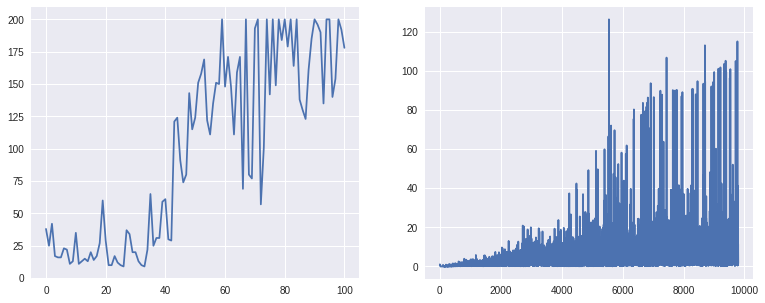

In [9]:
buffer = ReplayBuffer(5000)
env = gym.make("CartPole-v0")
agent = Agent()

rewards, loss = [], []
episode_reward = 0
state = env.reset()
buffer.new_episode(state)

for i in trange(10000):
  eps = .01 + .99 * math.exp(-i / 500) # close to .01 at 3500
  action = agent.act_e_greedy(buffer.cur_state(), eps)
  state, reward, terminal, _ = env.step(action)
  buffer.append(state, action, reward, terminal)
  episode_reward += reward
  
  if terminal:
    state = env.reset()
    buffer.new_episode(state)
    rewards.append(episode_reward)
    episode_reward = 0

  if i > 200:
    loss.append(agent.train_iter(buffer))
   
  if i > 200 and i % 100 == 0:
    agent.update_target_net()

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(rewards)
plt.subplot(132)
plt.plot(loss)